In [1]:
import pandas as pd
import numpy as np

from glob import glob
import re

from pybedtools import BedTool as BT

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib

from scipy.stats import mannwhitneyu as MWU
from math import log

### Downsampling

In this analysis, we have called peaks (macs2 in each replicate, then idr peaks on the results of the macs2 peaks) in all stages, with increasingly lower number of reads. 

The number of reads was chosen so as to have 100%, 90%, 80% etc of the amphioxus number.    
    
The question is, do we still have more peaks in the vertebrates with worse (less reads) experiments?

In [3]:
greg = {}

greg['Dre'] = pd.read_csv("./data/genomic_regions/intergenics_Dre.tsv.gz", sep='\t', header=None)
greg['Dre'].columns = ['chrom','start','end','gene1','gene2']
greg['Dre']['score'] = greg['Dre']['end'] - greg['Dre']['start']

greg['Bla'] = pd.read_csv("./data/genomic_regions/intergenics_Bla.tsv.gz", sep='\t', header=None)
greg['Bla'].columns = ['chrom','start','end','gene1','gene2']
greg['Bla']['score'] = greg['Bla']['end'] - greg['Bla']['start']

greg['Ola'] = pd.read_csv("./data/genomic_regions/intergenics_Ola.tsv.gz", sep='\t', header=None)
greg['Ola'].columns = ['chrom','start','end','gene1','gene2']
greg['Ola']['score'] = greg['Ola']['end'] - greg['Ola']['start']

greg['Mmu'] = pd.read_csv("./data/genomic_regions/intergenics_Mmu.tsv.gz", sep='\t', header=None)
greg['Mmu'].columns = ['chrom','start','end','gene1','gene2']
greg['Mmu']['score'] = greg['Mmu']['end'] - greg['Mmu']['start']

print( [(k,len(v)) for k,v in greg.items()])

[('Mmu', 18814), ('Bla', 18943), ('Dre', 19837), ('Ola', 15473)]


In [4]:
stages = {}
stages['Bla'] = ['15']
stages['Dre'] = ["8som"]
stages['Ola'] = ["8som"]

We will normalize the number of reads based on the amount of available genome in each species.    
That is the total genome minus the regions covered by the repeat masker.    
    
Unintuitively, medaka ends up with more available genome that zebrafish because of the very large number
of blacklisted regions in zebrafish.

In [5]:
genome_size = {'Dre': 1.37e9,
              'Bla' : 0.5e9,
              'Ola' : 0.87e9}
rep_regions = {'Dre' : 716927489,
              'Bla' : 152452412,
               'Ola': 23221380
              }
avail_genome = { k:genome_size[k]-rep_regions[k] for k in ['Dre','Bla','Ola']  }
avail_genome

{'Bla': 347547588.0, 'Dre': 653072511.0, 'Ola': 846778620.0}

In [6]:
# # This is how many reads the bla sample has.
# # It was much easier to hard code this number than to count in this notebook:

# We calculate coverage as the #ofReads per kilobase of available genome:
Bla_coverage = 9200000*1000/ avail_genome['Bla']
# the percentages are not exactly 70 or 80 etc, so we will force-smooth them a tiny bit to
# make the graphs better.
fixcols =[1,10,20,30,40,50,60,70,80,90,100]

We have the downsample series in the data subfolder, so lets load them up:

In [26]:
greg_ = BT().from_dataframe(greg['Dre']).sort()
pre_cols = ['chrom','start','end','gene1','gene2','score']
cols = []
    
for thing in glob("./data/atac_peaks/downsampling/zebra_danRer10_8som_*_idr01Peaks.bed.gz"):
    reads = int(re.findall(r"[0-9]+", thing)[2])
    
    #     The coverage in this experiment:
    cov = reads*1000/avail_genome['Dre']
    #    The coverage in relation to the Bla one
    cov = round(cov*100 / Bla_coverage,2)
    cov = int(round(cov))
    cols.append( cov )
    greg_ = greg_.intersect(b=BT( thing ), nonamecheck=True, c=True)

counts_Dre = greg_.to_dataframe(names=pre_cols+cols)   
counts_Dre = counts_Dre[pre_cols+ sorted(cols)]
counts_Dre.columns = pre_cols + fixcols

dre_melt1 = pd.melt(counts_Dre[['gene1']+fixcols], id_vars='gene1')
dre_melt1.columns = ['gene','pc','count']

dre_melt2 = pd.melt(counts_Dre[['gene2']+fixcols], id_vars='gene2')
dre_melt2.columns = ['gene','pc','count']

dre_melt = pd.concat([dre_melt1,dre_melt2]).groupby(['gene','pc']).sum().reset_index(drop=False)

Same for medaka:

In [27]:
greg_ = BT().from_dataframe(greg['Ola']).sort()
pre_cols = ['chrom','start','end','gene1','gene2','score']
cols = []
    
for thing in glob("./data/atac_peaks/downsampling/medaka_8som_*_idr01Peaks.bed.gz"):
    reads = int(re.findall(r"[0-9]+", thing)[1])
    
    cov = reads*1000/avail_genome['Ola']
    cov = round(cov*100 / Bla_coverage,2)
    cov = int(round(cov))
    
    cols.append( cov )
    greg_ = greg_.intersect(b=BT( thing ), nonamecheck=True, c=True)

counts_Ola = greg_.to_dataframe(names=pre_cols+cols)   
counts_Ola = counts_Ola[pre_cols+ sorted(cols)]
counts_Ola.columns = pre_cols + fixcols

ola_melt1 = pd.melt(counts_Ola[['gene1']+fixcols], id_vars='gene1')
ola_melt1.columns = ['gene','pc','count']

ola_melt2 = pd.melt(counts_Ola[['gene2']+fixcols], id_vars='gene2')
ola_melt2.columns = ['gene','pc','count']

ola_melt = pd.concat([ola_melt1,ola_melt2]).groupby(['gene','pc']).sum().reset_index(drop=False)

For amphioxus we'll only load two stages, the full non-downsampled one (101%) and the very minimally downsampled one (100%), which has only been downsampled so that the two replicates have the same number of reads.

In [37]:
org = "bla"
stage='15'

full_peaks = './data/atac_peaks/amphi_15_idrpeaks.bed.gz'
sub_peaks = './data/atac_peaks/downsampling/amphi_15_9200000_idr01Peaks.bed.gz'


greg_ = BT().from_dataframe(greg['Bla']).sort()
cols = ['chrom','start','end','gene1','gene2','score']

greg_ = greg_.intersect(b=BT( full_peaks ), nonamecheck=True, c=True)
greg_ = greg_.intersect(b=BT( sub_peaks ), nonamecheck=True, c=True)

counts_Bla = greg_.to_dataframe(names=cols + [101,100])

bla_melt1 = pd.melt(counts_Bla[['gene1']+[101,100]], id_vars='gene1')
bla_melt1.columns = ['gene','pc','count']

bla_melt2 = pd.melt(counts_Bla[['gene2']+[101,100]], id_vars='gene2')
bla_melt2.columns = ['gene','pc','count']

bla_melt = pd.concat([bla_melt1,bla_melt2]).groupby(['gene','pc']).sum().reset_index(drop=False)

In [38]:
bla_melt['species'] = 'bla'
ola_melt['species'] = 'ola'
dre_melt['species'] = 'dre'

In [39]:
bla_melt.head(2)

,gene,pc,count,species
0,BL00000,100,6,bla
1,BL00000,101,7,bla


In [40]:
ola_melt.head(2)

,gene,pc,count,species
0,ENSORLG00000000002,1,0,ola
1,ENSORLG00000000002,10,1,ola


In [41]:
dre_melt.head(2)

,gene,pc,count,species
0,ENSDARG00000000001,1,0,dre
1,ENSDARG00000000001,10,0,dre


In [42]:
toplot = pd.concat([dre_melt, ola_melt, bla_melt])
toplot.sample(5)

,gene,pc,count,species
166483,ENSORLG00000019726,90,4,ola
133702,ENSDARG00000070284,80,4,dre
122603,ENSDARG00000062770,80,8,dre
143676,ENSDARG00000075007,50,8,dre
131704,ENSORLG00000014929,10,3,ola


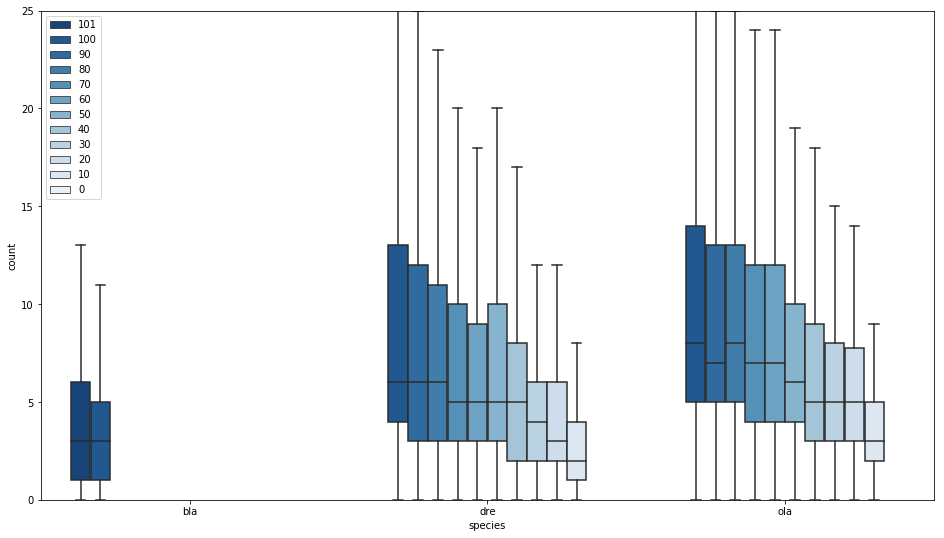

In [43]:
plt.figure(figsize=(16,9))



sns.boxplot(
    data=toplot,
    
    x = 'species',
    order= ['bla','dre','ola'],
    hue='pc',
    hue_order=[101,100,90,80,70,60,50,40,30,20,10,0],
    
    fliersize=0,
    y='count',
    palette='Blues_r'
)

plt.ylim((0,25))
plt.legend(loc='upper left')

Let's calculate some PValues:

In [44]:
lot = []
blavals = toplot.loc[(toplot.species=='bla') & (toplot.pc==101),'count'].values
blavals_sub = toplot.loc[(toplot.species=='bla') & (toplot.pc==100),'count'].values

for gn,g in toplot.groupby(['species','pc']):
    species,pc = gn
    if species=='bla':
        continue
    pv = MWU( g['count'].values , blavals, alternative='greater' ).pvalue
    pv_sub = MWU( g['count'].values , blavals_sub, alternative='greater' ).pvalue
    
    lot.append([ species, pc, pv_sub,pv])
    
    
df = pd.DataFrame(lot)
df.columns = ['species','% of reads','pVal to downsampled Amphi','pVal to full Amphi']
df

,species,% of reads,pVal to downsampled Amphi,pVal to full Amphi
0,dre,1,1.000000e+00,1.000000e+00
1,dre,10,1.000000e+00,1.000000e+00
2,dre,20,4.746324e-186,3.194226e-28
3,dre,30,8.176680e-251,1.137817e-55
4,dre,40,0.000000e+00,0.000000e+00
5,dre,50,0.000000e+00,0.000000e+00
6,dre,60,0.000000e+00,0.000000e+00
7,dre,70,0.000000e+00,0.000000e+00
8,dre,80,0.000000e+00,0.000000e+00
9,dre,90,0.000000e+00,0.000000e+00
